# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM on Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)




### Introduction <a name="introduction" />

1. Background

Samsen Pte. Ltd. is a well known Malay and Indian restaurant in Kuala Lumpur, Malaysia. The restaurant chain decided to expand its business in Singapore.
Food industry in Singapore is a lucrative business. One in four eats out in Singapore. Singapore is similar to Kuala Lumpur in many ways in terms of census.
The problem is to find optimal location in Singapore to open the restaurant.
Singapore is well connected city with good mix of all ethnicity - Indonesian, Malaysian, Indian, Chinese. 
This project can also be used for relocation from Kuala Lumpur to Singapore

Target Audience includes the multinational business owners who want to open new branch in Singapore or individuals who wants to relocate to Singapore.

2. Problem Description

Finding a Neighborhood in Singapore which is similar to the location of Samsen Pte. Ltd. in Kuala Lumpur which is nearer to MRT.



### Data <a name="data" />

1. List of MRTs  in Singapore : Web scraping wiki page https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations_by_planning_area

2.  Geo Coordinates of MRT location

3. Location intelligence  from Foursquare API : 1) Most Recommended venues in the neighbourhood of Kuala Lumpur where Samsen restaurant is located.
2) most recommended Venues in all neighbourhoods of Singapore within 1km of MRT
3) Planning area with highest rated asian restaurants.
4) Planning area with high Malay and Indian population



### Download and Import necessary modules

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 1. Download and Explore Dataset

In [4]:
#function to get location
def get_address(address):
    try:
        geolocator = Nominatim()
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        #print(address,latitude, longitude)
        listL = [latitude,longitude]
    except:
        listL = [0,0]
    return listL

##### Get address of KL location

In [5]:
#lat  = get_address('CC10, Singapore')
#print(lat)
KL_restaurant = 'Zam Zam Restaurant'
KL_venue = '50100 Kuala Lumpur'
KL_lat, KL_lng = get_address('55100 Kuala Lumpur')
print(KL_lat,KL_lng)

3.1516636 101.6943028


##### Collect List of MRTs  in Singapore : Web scraping wiki page https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations_by_planning_area

In [6]:
# get the dataframe from wiki table
#using beautifulsoup
from bs4 import BeautifulSoup
import requests
DF_sg_mrt = []
wikipedia_link='https://en.wikipedia.org/wiki/List_of_Singapore_MRT_stations'

raw_random_wikipedia_page=requests.get(wikipedia_link)
from bs4 import BeautifulSoup
soup = BeautifulSoup(raw_random_wikipedia_page.text, 'html.parser')
table = soup.find("table", { "class" : "wikitable" })
DF_sg_mrt = pd.DataFrame(columns=['Postal Code','Name of MRT','Planning Area'])
DF_sg_mrt.set_index( 'Postal Code',drop=True,inplace=True)
DF_sg_mrt.head()
for row in table.findAll("tr"):
    cells = row.findAll("td")
    cells = [ele.text.strip() for ele in cells]
    if((len(cells) > 4) and ( cells[4] == 'TBA' or int(cells[4][-4:]) > 2018)):
        #('*********',cells[1])
        continue
    if((len(cells) == 9) and (cells[1] != 'Not assigned')):
        #print(cells[1],cells[4][-4:])
        if(cells[4] == 'TBA' or int(cells[4][-4:-2]) > 2018):
            continue
        if(cells[1] == 'Not assigned'):
            cells[1] = cells[5] 
        names = cells[0].split('\xa0')
        names.sort(reverse=True)
        #print(names)
        cells[0] = names[0]
        if(cells[0] in DF_sg_mrt.index):
            DF_sg_mrt.loc[cells[0],'Planning Area'] +=',' + cells[7]
        else:
            DF_sg_mrt.loc[cells[0]] = [cells[1],cells[7]]
            
DF_sg_mrt.sort_values('Planning Area')


DF_sg_mrt.shape

(119, 2)

###  download geolocation of each MRT

In [7]:
DF_sg_mrt.reset_index(inplace=True)
listL = DF_sg_mrt['Postal Code'].apply(lambda x: get_address(x+',Singapore'))
DF_sg_mrt['Latitude'],DF_sg_mrt['Longitude'] = zip(*listL)

In [8]:
print(DF_sg_mrt.shape)
#DF_sg_mrt.groupby(['Latitude','Longitude']).count()

(119, 5)


### Get venue details of KL location and SG using foursquare api 

In [9]:
# the code cell is hidden for github submission


Your credentails:


In [10]:
def getNearbyVenues(names, latitudes, longitudes, search_query,radius=500):
    
    venues_list=[]
    for query in search_query:
        for name, lat, lng in zip(names, latitudes, longitudes):
        
        # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT
            , query
            )
            #print(url,name,end=',')
        # make the GET request
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                if (results == None):
                    print('*******',name)
        # return only relevant information for each nearby venue
                venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            except:
                print(name,query,'not available')
                
            
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [11]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/search/recommendations?'
#FOURSQUARE_SEARCH_URL='https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByRecommendations(names, latitudes, longitudes, categoryID, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['Town','Town Latitude','Town Longitude','VenueName','latitude','longitude','category']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
        for cat_id in categoryID:
            print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
            url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,cat_id)
            print(url)
    # make the GET request
            results = requests.get(url).json()
            jsonSub1 = []
            jsonSub2 = []
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
           # print(results['response']['group']['results'][0])
            try:
                for jsonSub1 in results['response']['group']['results']:
                      # JSON Results may not be in expected format or incomplete data, in that case, skip!
                    #print(jsonSub1['venue'])
                    jsonSub = jsonSub1['venue']
                    #print(jsonSub)
                        #jsonSub = jsonSub2['Venue']
                    ven_id = 0
                    try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                        ven_id   = jsonSub['id']
                        ven_cat  = jsonSub['categories'][0]['pluralName']
                        ven_CID  = jsonSub['categories'][0]['id']
                        ven_name = jsonSub['name']
                        ven_lat  = jsonSub['location']['lat']
                        ven_lng  = jsonSub['location']['lng']
                        venue_DF = venue_DF.append({
                                        'Town'      : name,
                                        'Town Latitude' : lat,
                                        'Town Longitude': lng,
                    #'VenueID'   : ven_id,
                                        'VenueName' : ven_name,
                   # 'score'     : 'nan',
                    #'catID'     : ven_CID,
                                        'latitude'  : ven_lat,
                                        'longitude' : ven_lng,
                                        'category'  : ven_cat
                                        }, ignore_index=True)
                    except:
                        continue
            except:
                print('**',name,'**')
                continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

In [12]:
FOURSQUARE_SEARCH_URL = 'https://api.foursquare.com/v2/venues/search?'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesByCategory(names, latitudes, longitudes, cat_id, radius=500):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    venue_columns = ['Town','Town Latitude','Town Longitude','VenueName','latitude','longitude','category']
    venue_DF = pd.DataFrame(columns=venue_columns)
    print("[#Start getVenuesByCategory]")
    for name, lat, lng in zip(names, latitudes, longitudes):
        for categoryID in cat_id:
       # cyclefsk2()
            print(name,",",end='')
        #print('getVenuesByCategory',categoryID,name) ; # DEBUG: be quiet
        # create the API request URL
            url = '{}client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            FOURSQUARE_SEARCH_URL,CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT,categoryID)
        # make the GET request
            results = requests.get(url).json()
        # Populate dataframe with the category venue results
        # Extracting JSON  data values
        #print(url)
            for jsonSub in results['response']['venues']:
            #print(jsonSub)
            # JSON Results may not be in expected format or incomplete data, in that case, skip!
                ven_id = 0
                try:
                # If there are any issue with a restaurant, retry or ignore and continue
                # Get location details
                    ven_id   = jsonSub['id']
                    ven_cat  = jsonSub['categories'][0]['pluralName']
                    ven_CID  = jsonSub['categories'][0]['id']
                    ven_name = jsonSub['name']
                    ven_lat  = jsonSub['location']['lat']
                    ven_lng  = jsonSub['location']['lng']
                    venue_DF = venue_DF.append({
                    'Town'      : name,
                    'Town Latitude' : lat,
                    'Town Longitude': lng,
                    #'VenueID'   : ven_id,
                    'VenueName' : ven_name,
                    #'score'     : 'nan',
                    #'category'  : ven_cat,
                    #'catID'     : ven_CID,
                    'latitude'  : ven_lat,
                    'longitude' : ven_lng,
                    'category'  : ven_cat}, ignore_index=True)
                except:
                    continue
    # END OF LOOP, return.
    print("\n[#Done getVenuesByCategory]")
    return(venue_DF)

In [13]:
FOURSQUARE_VENUE_SCORE = 'https://api.foursquare.com/v2/venues/'
# SEARCH VENUES BY CATEGORY

# Dataframe : venue_id_recover 
# - store venue id to recover failed venues id score retrieval later if foursquare limit is exceeded when getting score.
venue_id_rcols = ['VenueID','Score']
venue_id_recover = pd.DataFrame(columns=venue_id_rcols)

def getVenuesScoreById(venueID):
    global CLIENT_ID
    global CLIENT_SECRET
    global FOURSQUARE_EXPLORE_URL
    global FOURSQUARE_SEARCH_URL
    global VERSION
    global LIMIT
    global venue_id_recover
    print("[#getVenuesIDScore]")
    venID_URL = '{}{}?client_id={}&client_secret={}&v={}'.format(FOURSQUARE_VENUE_SCORE,venueID,CLIENT_ID,CLIENT_SECRET,VERSION)
    print(venID_URL)
    venID_score = 0.00
    # Process results
    try:
        venID_result = requests.get(venID_URL).json()
        venID_score  = venID_result['response']['venue']['rating']
    except: 
        venue_id_recover = venue_id_recover.append({'VenueID' : venueID, 'Score' : 0.0})
        cyclefsk2()
        return ["error",0.0]
    return ["success",venID_score]

### Analyse venues around current restaurant in KL location 

In [16]:
df_malay = getNearbyVenues([KL_venue],[KL_lat],[KL_lng],['food','stores'])
#df_malay = getVenuesByCategory([KL_venue],[KL_lat],[KL_lng],['4bf58dd8d48988d1f9941735','4bf58dd8d48988d142941735'])
df_malay.columns=['Name of MRT','Latitude','Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
# one hot encoding
df_malay.head()

,Name of MRT,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,50100 Kuala Lumpur,3.151664,101.694303,Restoran Jai Hind,3.151061,101.696074,Indian Restaurant
1,50100 Kuala Lumpur,3.151664,101.694303,Cafeteria DBKL,3.152154,101.694922,Asian Restaurant
2,50100 Kuala Lumpur,3.151664,101.694303,Syawarma Raihani Kebab,3.153069,101.696364,Kebab Restaurant
3,50100 Kuala Lumpur,3.151664,101.694303,KL Food Truck Feast,3.150329,101.694701,Restaurant
4,50100 Kuala Lumpur,3.151664,101.694303,Selangor Mansion Roti Banjir Special,3.151982,101.697446,Indian Restaurant


In [17]:
my_onehot = pd.get_dummies(df_malay[['Venue Category']], prefix="", prefix_sep="")

# add Town column back to dataframe
my_onehot['Name of MRT'] = df_malay['Name of MRT'] 

# move neighborhood column to the first column
fixed_columns = [my_onehot.columns[-1]] + list(my_onehot.columns[:-1])
my_onehot = my_onehot[fixed_columns]

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(my_onehot.shape[0]))

# Regroup rows by town and mean of frequency occurrence per category.
my_grouped = my_onehot.groupby('Name of MRT').mean().reset_index()

print('One hot encoding re-group returned "{}" rows.'.format(my_grouped.shape[0]))
my_grouped.head()
#df_malay

One hot encoding returned "100" rows.
One hot encoding re-group returned "1" rows.


,Name of MRT,Art Gallery,Asian Restaurant,Athletics & Sports,Bakery,Boutique,Bubble Tea Shop,Burger Joint,Cafeteria,Café,Chettinad Restaurant,Clothing Store,Coffee Shop,Cosmetics Shop,Donut Shop,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Fried Chicken Joint,Gym,Hotel,Indian Restaurant,Kebab Restaurant,Malay Restaurant,Men's Store,Middle Eastern Restaurant,Monument / Landmark,Night Market,Pizza Place,Restaurant,Sandwich Place,Shop & Service,South Indian Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Theater,Vegetarian / Vegan Restaurant,Wine Bar,Women's Store
0,50100 Kuala Lumpur,0.01,0.04,0.02,0.04,0.02,0.01,0.02,0.03,0.07,0.02,0.01,0.01,0.01,0.02,0.02,0.01,0.04,0.02,0.01,0.01,0.01,0.22,0.02,0.09,0.01,0.01,0.01,0.01,0.02,0.03,0.01,0.01,0.01,0.02,0.01,0.02,0.01,0.02,0.01,0.01


In [18]:
df_malay['Venue Category'].value_counts()
#DF_MY_Venues = pd.DataFrame(df_malay[['Venue Category']].groupby('Venue Category').count())
#DF_MY_Venues.columns = ['Venue Category', 'count']

Indian Restaurant                22
Malay Restaurant                  9
Café                              7
Food Court                        4
Bakery                            4
Asian Restaurant                  4
Cafeteria                         3
Restaurant                        3
Pizza Place                       2
Donut Shop                        2
Vegetarian / Vegan Restaurant     2
Boutique                          2
Kebab Restaurant                  2
Burger Joint                      2
Fast Food Restaurant              2
Chettinad Restaurant              2
Food Truck                        2
Athletics & Sports                2
Speakeasy                         2
Steakhouse                        2
Wine Bar                          1
Art Gallery                       1
Clothing Store                    1
Sporting Goods Shop               1
South Indian Restaurant           1
Flea Market                       1
Theater                           1
Cosmetics Shop              

#### analyse venues in SG around MRT

In [19]:
df_venues = getNearbyVenues(DF_sg_mrt['Name of MRT'],DF_sg_mrt['Latitude'],DF_sg_mrt['Longitude'],['food','stores'])
#df_venues = getVenuesByCategory(DF_sg_mrt['Name of MRT'],DF_sg_mrt['Latitude'],DF_sg_mrt['Longitude'],['4bf58dd8d48988d1f9941735','4bf58dd8d48988d142941735'])

In [20]:
df_venues.to_csv('SG_venues.csv')
df_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jurong East,1.333115,103.742297,Tonkatsu by Ma Maison とんかつ マメゾン (Tonkatsu by M...,1.333668,103.742818,Japanese Restaurant
1,Jurong East,1.333115,103.742297,Song Fa Bak Kut Teh 松發肉骨茶,1.333394,103.743420,Chinese Restaurant
2,Jurong East,1.333115,103.742297,Johan Paris,1.334083,103.742384,Bakery
3,Jurong East,1.333115,103.742297,Dian Xiao Er 店小二,1.333447,103.743094,Chinese Restaurant
4,Jurong East,1.333115,103.742297,Paradise Dynasty 樂天皇朝,1.334364,103.743612,Chinese Restaurant


In [21]:
df_venues.shape
df_venues.columns = ['Name of MRT','Latitude','Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']

In [22]:
df_venues.groupby('Name of MRT').count().shape

(119, 6)

In [23]:
# Count number of categories that can be curated.
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 308 uniques categories.


In [24]:
# Check top 10 most frequently occuring venue type
DF_stats = pd.DataFrame(df_venues.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)[:10])
DF_stats.reset_index(inplace=True)
DF_stats

,Venue Category,Venue
0,Chinese Restaurant,527
1,Café,498
2,Food Court,390
3,Japanese Restaurant,353
4,Asian Restaurant,313
5,Bakery,245
6,Indian Restaurant,241
7,Noodle House,203
8,Fast Food Restaurant,202
9,Coffee Shop,182


In [25]:
DF_my_stats = pd.DataFrame(df_malay.groupby('Venue Category')['Venue'].count().sort_values(ascending=False)[:10])
DF_my_stats.reset_index(inplace=True)
DF_my_stats

,Venue Category,Venue
0,Indian Restaurant,22
1,Malay Restaurant,9
2,Café,7
3,Food Court,4
4,Asian Restaurant,4
5,Bakery,4
6,Cafeteria,3
7,Restaurant,3
8,Burger Joint,2
9,Food Truck,2


### visualize plots 

In [26]:

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
def pieChart(sizes,labels,title):
    explode = [0  for x in range(len(sizes))]
    explode[1] = 0.1
    #print(explode)
    #(0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.set_title(title)
    plt.savefig(title+'_top_venues.png')
    plt.show()

def barChart(sizes,labels,title):
    
    y_pos = np.arange(len(labels))
    plt.bar(y_pos, sizes, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation=90)
    plt.ylabel('Venues Frequency')
    plt.title(title)
    plt.savefig(title+'_top_venues.png')
    plt.show()

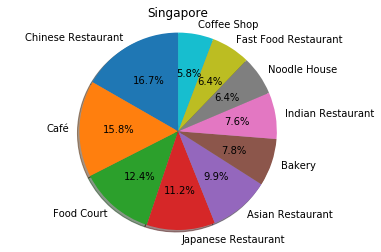

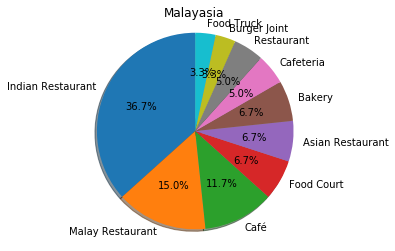

In [27]:
pieChart( DF_stats['Venue'],DF_stats['Venue Category'],'Singapore')
pieChart(DF_my_stats['Venue'],DF_my_stats['Venue Category'],'Malayasia')

In [28]:
df_sg_my = pd.concat([df_malay,df_venues], axis=0)
df_sg_my.head()

,Name of MRT,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,50100 Kuala Lumpur,3.151664,101.694303,Restoran Jai Hind,3.151061,101.696074,Indian Restaurant
1,50100 Kuala Lumpur,3.151664,101.694303,Cafeteria DBKL,3.152154,101.694922,Asian Restaurant
2,50100 Kuala Lumpur,3.151664,101.694303,Syawarma Raihani Kebab,3.153069,101.696364,Kebab Restaurant
3,50100 Kuala Lumpur,3.151664,101.694303,KL Food Truck Feast,3.150329,101.694701,Restaurant
4,50100 Kuala Lumpur,3.151664,101.694303,Selangor Mansion Roti Banjir Special,3.151982,101.697446,Indian Restaurant


In [29]:
# one hot encoding


sg_onehot = pd.get_dummies(df_sg_my[['Venue Category']], prefix="", prefix_sep="")

# add Town column back to dataframe
sg_onehot['Name of MRT'] = df_sg_my['Name of MRT'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

# Check returned one hot encoding data:
print('One hot encoding returned "{}" rows.'.format(sg_onehot.shape[0]))

# Regroup rows by town and mean of frequency occurrence per category.
sg_grouped = sg_onehot.groupby('Name of MRT').mean().reset_index()

print('One hot encoding re-group returned "{}" rows.'.format(sg_grouped.shape[0]))
sg_grouped

One hot encoding returned "7081" rows.
One hot encoding re-group returned "120" rows.


,Name of MRT,ATM,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Bay,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Candy Store,Cantonese Restaurant,Casino,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Auditorium,College Bookstore,College Cafeteria,College Residence Hall,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laundromat,Light Rail Station,Lingerie Store,Lounge,Luggage Store,Macanese Restaurant,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,Night Market,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Portuguese Restaurant,Post Office,Pub,Public Art,Racetrack,Ramen Restaurant,Reservoir,Resort,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Lodge,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Swiss Restaurant,Szechuan Restaurant,Ta

In [30]:
# top visited venues

num_top_venues = 10
for town in sg_grouped['Name of MRT']:
    print("# Town=< "+town+" >")
    temp = sg_grouped[sg_grouped['Name of MRT'] == town].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    temp1 = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    print('\n')
    #pieChart(temp1['freq'],temp1['venue'],town)

# Town=< 50100 Kuala Lumpur >
               venue  freq
0  Indian Restaurant  0.22
1   Malay Restaurant  0.09
2               Café  0.07
3         Food Court  0.04
4             Bakery  0.04
5   Asian Restaurant  0.04
6          Cafeteria  0.03
7         Restaurant  0.03
8         Steakhouse  0.02
9         Food Truck  0.02


# Town=< Admiralty >
                  venue  freq
0  Fast Food Restaurant  0.20
1                  Café  0.16
2            Food Court  0.12
3                Bakery  0.12
4           Supermarket  0.08
5      Sushi Restaurant  0.08
6                   ATM  0.04
7        Breakfast Spot  0.04
8      Halal Restaurant  0.04
9      Asian Restaurant  0.04


# Town=< Aljunied >
                           venue  freq
0             Chinese Restaurant  0.15
1               Asian Restaurant  0.09
2                     Food Court  0.09
3                   Noodle House  0.08
4             Dim Sum Restaurant  0.08
5             Seafood Restaurant  0.06
6  Vegetarian / Vegan Res

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name of MRT']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
town_venues_sorted = pd.DataFrame(columns=columns)
town_venues_sorted['Name of MRT'] = sg_grouped['Name of MRT']

for ind in np.arange(sg_grouped.shape[0]):
    town_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

print(town_venues_sorted.shape)
town_venues_sorted.head()

(120, 11)


,Name of MRT,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,50100 Kuala Lumpur,Indian Restaurant,Malay Restaurant,Café,Food Court,Bakery,Asian Restaurant,Restaurant,Cafeteria,Speakeasy,Athletics & Sports
1,Admiralty,Fast Food Restaurant,Café,Bakery,Food Court,Sushi Restaurant,Supermarket,ATM,Halal Restaurant,Asian Restaurant,Snack Place
2,Aljunied,Chinese Restaurant,Food Court,Asian Restaurant,Noodle House,Dim Sum Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Café,Coffee Shop,Indian Restaurant
3,Ang Mo Kio,Food Court,Japanese Restaurant,Fast Food Restaurant,Sushi Restaurant,Sandwich Place,Noodle House,Dessert Shop,Snack Place,Halal Restaurant,Coffee Shop
4,Bartley,Noodle House,Café,Bus Stop,Bus Station,Metro Station,Korean Restaurant,Asian Restaurant,Pet Store,Indian Restaurant,Food Truck


### Methodology <a name="methodology"/>
### Clustering Neighborhoods

In [33]:
kclusters = 15
sg_grouped_clustering = sg_grouped.drop('Name of MRT', 1)
#sg_grouped_clustering=sg_grouped_clustering.append(my_grouped.drop('Name of MRT', 1),ignore_index=True)
sg_grouped_clustering.fillna(0.0,inplace=True)
#my_grouped.drop('Name of MRT', 1)
print(sg_grouped_clustering.shape)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(sg_grouped_clustering)
print(kmeans.labels_)
print(len(kmeans.labels_))
print('cluster of KL location',kmeans.labels_[0])
KL_cluster = kmeans.labels_[0]
town_venues_sorted = town_venues_sorted.set_index("Name of MRT")
sg_merged = DF_sg_mrt.set_index("Name of MRT")
# add clustering labels
town_venues_sorted['Cluster Labels'] = kmeans.labels_
town_venues_sorted['Cluster Labels'] = town_venues_sorted['Cluster Labels'].astype(int)
# merge sg_grouped with singapore_average_rental_prices_by_town to add latitude/longitude for each neighborhood
sg_merged = sg_merged.join(town_venues_sorted)
#sg_merged['Cluster Labels'] = sg_merged['Cluster Labels'].astype(int)
sg_merged.head()


(120, 311)
[ 4 14  0 14  2 12  1 14  5  5 12  7 12  0 14  7  5 12 14 12  1  5  7 14
 12 10  7  0  0 14 12  3 14  0  0 12  2 12  3  0 12  4  0  3  6  6  1 13
 12  7  1  4  1 12  5  0  0  7 14 12  1  2 12 14  7  8  2  5 12  7 14  5
  5  0  0  7 12 12 12  0  2 14 14  1  3 14  5 12  0  4 14  7  1  1  7 12
 12 12  5  2  7  7  2  0  3 12  5  1  1 11  9  6  5  2 14  2 14  5  1  2]
120
cluster of KL location 4


,Postal Code,Planning Area,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,,,,
Jurong East,NS1,"Jurong East,Jurong East",1.333115,103.742297,Japanese Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Korean Restaurant,Café,Asian Restaurant,Department Store,Sandwich Place,Italian Restaurant,12
Bukit Batok,NS2,Bukit Batok,1.349057,103.749591,Chinese Restaurant,Food Court,Café,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Bakery,Malay Restaurant,Italian Restaurant,Sandwich Place,1
Bukit Gombak,NS3,Bukit Batok,1.358893,103.751825,Food Court,Chinese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Malay Restaurant,Steakhouse,Sandwich Place,Fast Food Restaurant,Stadium,5
Choa Chu Kang,NS4,Choa Chu Kang,1.385317,103.744325,Food Court,Bakery,Fast Food Restaurant,Chinese Restaurant,Portuguese Restaurant,Coffee Shop,Sandwich Place,Thai Restaurant,Asian Restaurant,Bubble Tea Shop,14
Yew Tee,NS5,Choa Chu Kang,1.397461,103.747401,Fast Food Restaurant,Sandwich Place,Diner,Food Court,Japanese Restaurant,Asian Restaurant,Shopping Mall,Café,Train Station,Snack Place,14


In [34]:
# create map
map_clusters = folium.Map(location=[sg_merged['Latitude'][0], sg_merged['Longitude'][0]])

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged.index, sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save('SG_Venue_cluster.png')
map_clusters

### Analysis <a name="analysis"/>

In [41]:
DF_data_rec = sg_merged.loc[sg_merged['Cluster Labels'] == KL_cluster, sg_merged.columns[[0]+[1] + list(range(4, sg_merged.shape[1]))]]
DF_data_rec.to_csv('final_reco.csv')
DF_data_rec

,Postal Code,Planning Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,,
Farrer Park,NE8,"Kallang, Rochor",Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,Diner,Asian Restaurant,Restaurant,Dumpling Restaurant,Sushi Restaurant,4
Rochor,DT13,Rochor,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant,Hostel,French Restaurant,Dessert Shop,Sushi Restaurant,4
Jalan Besar,DT22,Rochor,Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Indonesian Restaurant,Hotel,Bakery,Hostel,Dumpling Restaurant,4


In [42]:

#my_grouped.set_index('Name of MRT',inplace=True)
town_venues_sorted.head(1)

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,
50100 Kuala Lumpur,Indian Restaurant,Malay Restaurant,Café,Food Court,Bakery,Asian Restaurant,Restaurant,Cafeteria,Speakeasy,Athletics & Sports,4


In [44]:
DF_data_rec['Planning Area']

Name of MRT
Farrer Park    Kallang, Rochor
Rochor                  Rochor
Jalan Besar             Rochor
Name: Planning Area, dtype: object

In [45]:
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,
Bukit Batok,NS2,Chinese Restaurant,Food Court,Café,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Bakery,Malay Restaurant,Italian Restaurant,Sandwich Place,1
Yishun,NS13,Chinese Restaurant,Food Court,Fast Food Restaurant,Hainan Restaurant,Noodle House,Fried Chicken Joint,Italian Restaurant,Coffee Shop,Café,Dim Sum Restaurant,1
Toa Payoh,NS19,Chinese Restaurant,Food Court,Snack Place,Asian Restaurant,Café,Bakery,Coffee Shop,Fast Food Restaurant,Steakhouse,Convenience Store,1
Simei,EW3,Chinese Restaurant,Café,Fast Food Restaurant,Japanese Restaurant,Snack Place,Noodle House,Soup Place,Hotpot Restaurant,Bakery,Hong Kong Restaurant,1
Tiong Bahru,EW17,Chinese Restaurant,Café,Food Court,Japanese Restaurant,Coffee Shop,Halal Restaurant,Noodle House,Soup Place,Bakery,Korean Restaurant,1
Joo Koon,EW29,Fast Food Restaurant,Hong Kong Restaurant,Fried Chicken Joint,Food Court,Snack Place,Bus Station,Bakery,Italian Restaurant,Chinese Breakfast Place,Chinese Restaurant,1
HarbourFront,NE1,Chinese Restaurant,Bakery,Fast Food Restaurant,Japanese Restaurant,German Restaurant,Food Court,Clothing Store,Korean Restaurant,Coffee Shop,Sushi Restaurant,1
Potong Pasir,NE10,Chinese Restaurant,Food Court,Fast Food Restaurant,Noodle House,Bakery,Asian Restaurant,Convenience Store,Snack Place,Café,Cafeteria,1
Serangoon,NE12,Chinese Restaurant,Japanese Restaurant,Fast Food Restaurant,Korean Restaurant,Noodle House,Coffee Shop,Bakery,Café,Sandwich Place,Sushi Restaurant,1


In [46]:
sg_merged.loc[sg_merged['1st Most Common Venue'] == 'Indian Restaurants', sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,


In [47]:
sg_merged.loc[sg_merged['1st Most Common Venue'] == 'Asian Restaurant', sg_merged.columns[[0] + list(range(4, sg_merged.shape[1]))]]

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,
Sembawang,NS11,Asian Restaurant,Fast Food Restaurant,Chinese Restaurant,Café,Japanese Restaurant,Bistro,Food Court,Coffee Shop,BBQ Joint,Sushi Restaurant,14
Haw Par Villa,CC25,Asian Restaurant,Food Court,Korean Restaurant,Food Truck,Sculpture Garden,Comfort Food Restaurant,Bus Station,Metro Station,Miscellaneous Shop,Yunnan Restaurant,13


### get population distribution per planning area

In [53]:
# token variable is hidden

In [54]:
def getPlanningAreas():
    url = 'https://developers.onemap.sg/privateapi/popapi/getPlanningareaNames?token={}'.format(token)
    venues_list=pd.DataFrame(columns=['Planning Area'])
    
    try:
        results = requests.get(url).json()
        
        venues_list['Planning Area'] = [(
                 v['pln_area_n'] 
                ) for v in results]
    except:
        print(area,' data not available')
        
    return venues_list    

def getEthnicGroups(areas):
    #{     "planning_area": "Bedok",     "chinese": 102310,     "malays": 23178,     "indian": 13028,     "others": 5884,     "year": 2010,   }
    venues_list = []
    #venues_list=pd.DataFrame(columns=['Planning Area','chinese','malays','others','year'])
    i=0
    for area in areas:
        url = 'https://developers.onemap.sg/privateapi/popapi/getEthnicGroup?token={}&planningArea={}&year=2015'.format(token,area)
        try:
          #  print(url)
            result = requests.get(url)
            results = result.json()
            #print (results)
            v = results[0]
            #print(v['chinese'],v['malays'],v['indian'],v['others'],v['year'])
            venues_list.append( [
                 area,
                 v['chinese'],
                 v['malays']
                 ,v['indian']
                 ,v['others']
                 ,v['year']
            ] )
            i = i +1
        except Exception as e:
            print(area,' data not available...',str(e))
            
        DF_venues = pd.DataFrame(venues_list,columns=['Planning Area','chines','malays','indian','others','year'])
        
    return DF_venues

In [55]:
df_ethnic = getPlanningAreas()
#df_ethnicity = getEthnicGroups(df_ethnic['Planning Area'])
#df_ethnicity.head()
df_ethnic.head()

,Planning Area
0,MARINE PARADE
1,NORTH-EASTERN ISLANDS
2,PIONEER
3,JURONG WEST
4,KALLANG


In [61]:
df_ethnicity = getEthnicGroups(df_ethnic['Planning Area'])
df_ethnicity.head()

,Planning Area,chines,malays,indian,others,year
0,MARINE PARADE,36630,3510,6020,2590,2015
1,NORTH-EASTERN ISLANDS,0,0,0,0,2015
2,PIONEER,0,0,0,0,2015
3,JURONG WEST,190190,48630,27080,6700,2015
4,KALLANG,75790,7970,14490,2960,2015


In [62]:
DF_data_rec['Planning Area']

Name of MRT
Farrer Park    Kallang, Rochor
Rochor                  Rochor
Jalan Besar             Rochor
Name: Planning Area, dtype: object

In [63]:
df_ethnicity['malay_india'] = df_ethnicity['malays'] + df_ethnicity['indian']
df_ethnicity.sort_values(by='malay_india',ascending=False)

,Planning Area,chines,malays,indian,others,year,malay_india
34,WOODLANDS,153740,62310,27800,6380,2015,90110
28,TAMPINES,175470,56010,21560,8190,2015,77570
3,JURONG WEST,190190,48630,27080,6700,2015,75710
14,BEDOK,208880,44000,25090,11790,2015,69090
43,YISHUN,142300,33940,20250,5520,2015,54190
19,CHOA CHU KANG,123460,29620,16480,4800,2015,46100
24,SENGKANG,160580,22590,18200,5320,2015,40790
6,PASIR RIS,93900,28440,11910,5650,2015,40350
7,HOUGANG,181690,17650,18050,4920,2015,35700
17,BUKIT BATOK,102080,19570,13710,3910,2015,33280


In [64]:
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[0]]

Name of MRT
Farrer Park     NE8
Rochor         DT13
Jalan Besar    DT22
Name: Postal Code, dtype: object

In [65]:
print(df_ethnicity[(df_ethnicity['Planning Area'] == 'KALLANG')])
print(df_ethnicity[(df_ethnicity['Planning Area'] == 'BEDOK')])
print(df_ethnicity[(df_ethnicity['Planning Area'] == 'ROCHOR')])

  Planning Area  chines  malays  indian  others  year  malay_india
4       KALLANG   75790    7970   14490    2960  2015        22460
   Planning Area  chines  malays  indian  others  year  malay_india
14         BEDOK  208880   44000   25090   11790  2015        69090
   Planning Area  chines  malays  indian  others  year  malay_india
54        ROCHOR   10470     650    2970     530  2015         3620


In [46]:
DF_sg_mrt[DF_sg_mrt['Name of MRT']=='Woodlands']


,Postal Code,Name of MRT,Planning Area,Latitude,Longitude
7,TE2,Woodlands,Woodlands,1.437388,103.787675


In [47]:
df_ethnicity.loc[(df_ethnicity['Planning Area'] =='WOODLANDS')]

,Planning Area,chines,malays,indian,others,year,malay_india
34,WOODLANDS,153740,62310,27800,6380,2015,90110


In [48]:
sg_merged.loc['Woodlands']
#sg_merged.head()

Postal Code                                TE2
Planning Area                        Woodlands
Latitude                               1.43739
Longitude                              103.788
1st Most Common Venue               Food Court
2nd Most Common Venue      Japanese Restaurant
3rd Most Common Venue                     Café
4th Most Common Venue       Chinese Restaurant
5th Most Common Venue         Asian Restaurant
6th Most Common Venue     Fast Food Restaurant
7th Most Common Venue                   Bakery
8th Most Common Venue              Pizza Place
9th Most Common Venue              Snack Place
10th Most Common Venue           Shopping Mall
Cluster Labels                               7
Name: Woodlands, dtype: object

In [49]:
df_ethnicity.sort_values(by='malay_india',ascending=False)[0:5]

,Planning Area,chines,malays,indian,others,year,malay_india
34,WOODLANDS,153740,62310,27800,6380,2015,90110
28,TAMPINES,175470,56010,21560,8190,2015,77570
3,JURONG WEST,190190,48630,27080,6700,2015,75710
14,BEDOK,208880,44000,25090,11790,2015,69090
43,YISHUN,142300,33940,20250,5520,2015,54190


In [66]:
sg_merged.loc['Tampines']

Postal Code                                 EW2
Planning Area                 Tampines,Tampines
Latitude                                1.29914
Longitude                               103.773
1st Most Common Venue                      Café
2nd Most Common Venue                Food Truck
3rd Most Common Venue               Bus Station
4th Most Common Venue          Asian Restaurant
5th Most Common Venue        Italian Restaurant
6th Most Common Venue      Gym / Fitness Center
7th Most Common Venue                     Diner
8th Most Common Venue               Pizza Place
9th Most Common Venue              Concert Hall
10th Most Common Venue    Performing Arts Venue
Cluster Labels                                2
Name: Tampines, dtype: object

# Town=< Kallang >
                venue  freq
0         Snack Place  0.12
1           BBQ Joint  0.12
2          Food Court  0.12
3     Thai Restaurant  0.09
4  Chinese Restaurant  0.09
5          Soup Place  0.06
6              Hostel  0.06
7    Malay Restaurant  0.06
8   Indian Restaurant  0.06
9  Seafood Restaurant  0.06




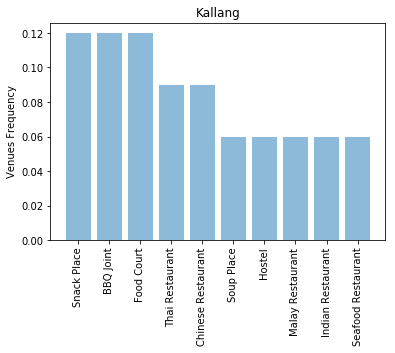

# Town=< Rochor >
                           venue  freq
0              Indian Restaurant  0.32
1  Vegetarian / Vegan Restaurant  0.16
2                           Café  0.09
3             Chinese Restaurant  0.07
4                         Hostel  0.03
5              French Restaurant  0.03
6               Asian Restaurant  0.03
7               Sushi Restaurant  0.03
8      Middle Eastern Restaurant  0.03
9                     Food Court  0.03




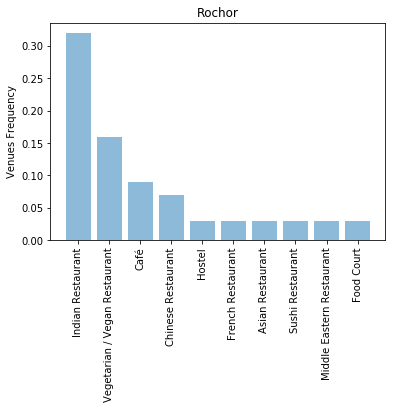

# Town=< Bedok >
                  venue  freq
0   Japanese Restaurant  0.07
1    Chinese Restaurant  0.07
2      Asian Restaurant  0.05
3        Sandwich Place  0.05
4            Food Court  0.05
5      Sushi Restaurant  0.05
6   Fried Chicken Joint  0.04
7  Fast Food Restaurant  0.04
8                Bakery  0.04
9          Noodle House  0.03




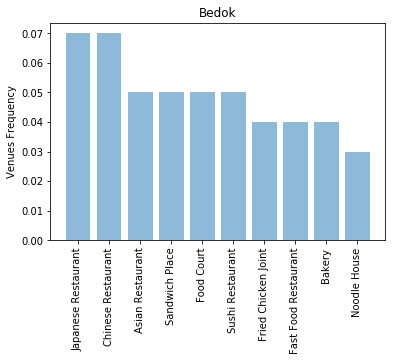

# Town=< Woodlands >
                  venue  freq
0            Food Court  0.11
1   Japanese Restaurant  0.10
2                  Café  0.07
3      Asian Restaurant  0.07
4           Snack Place  0.06
5  Fast Food Restaurant  0.05
6           Pizza Place  0.04
7    Chinese Restaurant  0.04
8                Bakery  0.03
9     Indian Restaurant  0.03




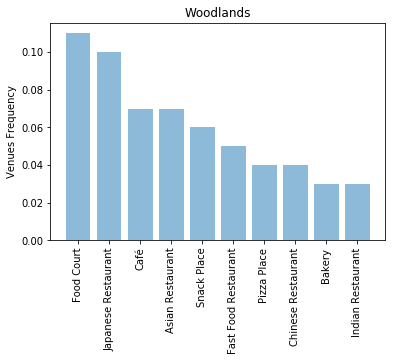

# Town=< Tampines >
                   venue  freq
0                   Café  0.33
1             Food Truck  0.09
2            Bus Station  0.06
3       Asian Restaurant  0.06
4     Athletics & Sports  0.03
5     Chinese Restaurant  0.03
6                 Museum  0.03
7   Gym / Fitness Center  0.03
8  Performing Arts Venue  0.03
9            Coffee Shop  0.03




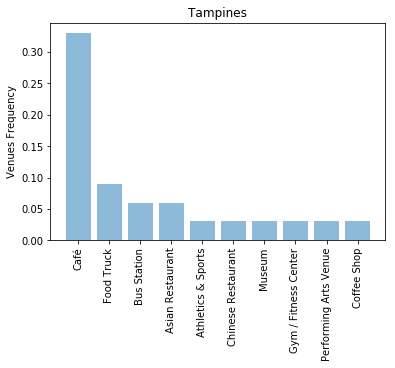

# Town=< Yishun >
                  venue  freq
0    Chinese Restaurant  0.13
1            Food Court  0.08
2  Fast Food Restaurant  0.06
3     Hainan Restaurant  0.05
4          Noodle House  0.05
5   Fried Chicken Joint  0.05
6                  Café  0.04
7           Coffee Shop  0.04
8    Italian Restaurant  0.04
9                Bakery  0.02




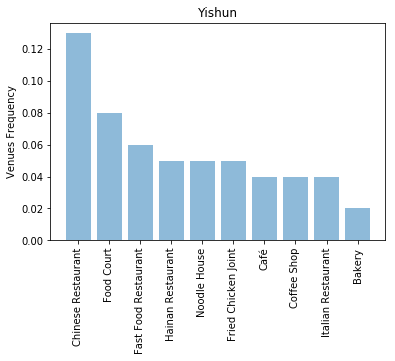

# Town=< Sengkang >
                  venue  freq
0                  Café  0.13
1            Steakhouse  0.09
2             Cafeteria  0.09
3            Restaurant  0.09
4           Snack Place  0.09
5        Sandwich Place  0.09
6         Deli / Bodega  0.04
7      Asian Restaurant  0.04
8  Fast Food Restaurant  0.04
9     College Cafeteria  0.04




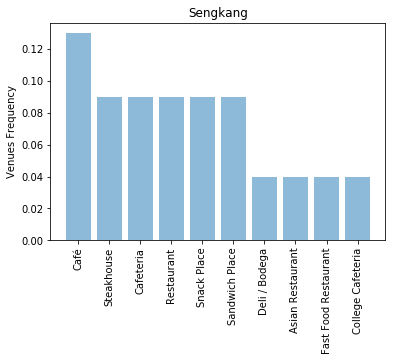

# Town=< Pasir Ris >
                   venue  freq
0                   Café  0.31
1            Bus Station  0.09
2             Food Truck  0.09
3       Asian Restaurant  0.06
4     Italian Restaurant  0.03
5     Athletics & Sports  0.03
6     Chinese Restaurant  0.03
7                 Museum  0.03
8  Performing Arts Venue  0.03
9            Coffee Shop  0.03




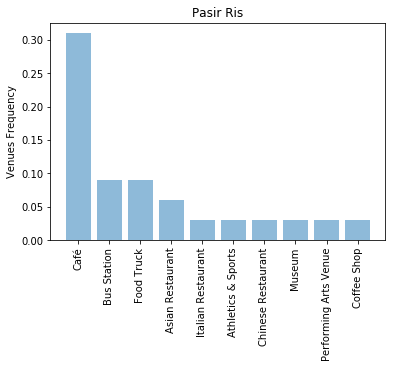

In [69]:
for town in ['Kallang','Rochor','Bedok','Woodlands','Tampines','Yishun','Sengkang','Pasir Ris']:
    print("# Town=< "+town+" >")
    temp = sg_grouped[sg_grouped['Name of MRT'] == town].T.reset_index()
    
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    temp1 = temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues)
    print('\n')
    barChart(temp1['freq'],temp1['venue'],town)

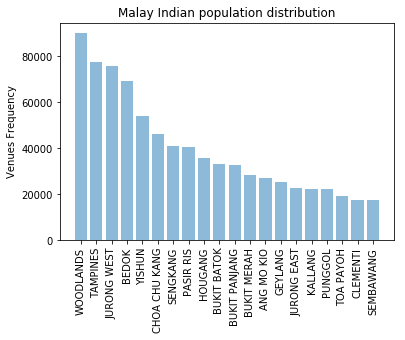

In [68]:
df_top_ten = df_ethnicity.sort_values(by='malay_india',ascending=False)[0:20]
barChart(df_top_ten['malay_india'],df_top_ten['Planning Area'],'Malay Indian population distribution')


### Results and Discussion  <a name="results" />

#### The location in SGs which are similar to Malaysia  are :-

In [72]:
DF_data_rec = sg_merged.loc[sg_merged['Cluster Labels'] == KL_cluster, sg_merged.columns[[0]+[1] + list(range(4, sg_merged.shape[1]))]]
DF_data_rec.to_csv('final_reco.csv')
DF_data_rec

,Postal Code,Planning Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
Name of MRT,,,,,,,,,,,,,
Farrer Park,NE8,"Kallang, Rochor",Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Fried Chicken Joint,Diner,Asian Restaurant,Restaurant,Dumpling Restaurant,Sushi Restaurant,4
Rochor,DT13,Rochor,Indian Restaurant,Vegetarian / Vegan Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant,Hostel,French Restaurant,Dessert Shop,Sushi Restaurant,4
Jalan Besar,DT22,Rochor,Indian Restaurant,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Asian Restaurant,Indonesian Restaurant,Hotel,Bakery,Hostel,Dumpling Restaurant,4


#### After descriptive analysis of population distrubution in different areas of singapore. The following areas have high malay and indian population and low malay and indian restaurant but good number of recommended for restuarants

1. Bedok 
2. woodlands 
3. yishun

### Conclusion <a name="conclusion" />

After clustering and descriptive analytics , the following areas/MRT can be recommended :-
    1. Farrer Park MRT (Area:- Kallang )
    2. Rochor MRT (Area :- Rochor)
    3. Jalan Besar MRT (Area :- Rochor)
    4. Bedok / Bedok North / Bedok Reservoir (Area :- Bedok)
    5. woodlands MRT (Area :- Woodlands)
    6. Yishun MRT (Area :- Yishun)
    
 Further based commercial property availability and rentals, the areas can be prioritised and presented to the client. Based on the budget , business owners can make final decision